# Welcome to the notebook to find a way to find your best house 🏠 
## Your house should be full of Love, Secure and Peace ❤️

### Players who have a role: Adel, Parnian, Shaghayegh, Ali

### Project Github: [house_price_estimation](https://github.com/alirahmani93/house_price_estimation)

<img src="../reports/1700600488911.jpg" alt="Alternative text" />

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import sys
sys.path.append('..')
from preprocess import cleaner
import utils
%config IPCompleter.use_jedi = False

In [2]:
raw_df = pd.read_csv('../data/Post-2023-11-21.csv')

/tmp/ipykernel_32241/1915378638.py:1: DtypeWarning: Columns (10,11,12,13,16,17,42,55,56,57,58,59,68,69) have mixed types. Specify dtype option on import or set low_memory=False.
  raw_df = pd.read_csv('../data/Post-2023-11-21.csv')


In [3]:
cleaned_df = cleaner.Cleaner(raw_df,min_dist=2.5).transform()[:5000]

HERE222222
Here 4


In [4]:
cleaned_df.if_near.value_counts()

if_near
0.0    1949
1.0    1638
Name: count, dtype: int64

In [5]:
raw_df.shape

(98414, 70)

In [6]:
cleaned_df.columns

Index(['business_type', 'district', 'price', 'elevator', 'parking', 'depot',
       'meter', 'rooms', 'real_state_agent', 'year', 'floor_0', 'price_m2',
       'age', 'loc_name', 'if_near'],
      dtype='object')

In [7]:
cleaned_df.head(2)

,business_type,district,price,elevator,parking,depot,meter,rooms,real_state_agent,year,floor_0,price_m2,age,loc_name,if_near
0,personal,pirouzi,3000000000,NaN,NaN,True,45,1,0,1380,2,66666666.666667,22,pirouzi,1.0
1,personal,saadat-abad,49999998976,True,True,True,220,4,0,1399,3,227272722.618182,3,saadat-abad,0.0


### EDA - outliers

In [8]:
print('the max price : ',cleaned_df['price'].max())
print('the min price : ',cleaned_df['price'].min())

the max price :  575000018944
the min price :  515000000


In [9]:
# seperating the 1 percentile from both ends of the price column

In [10]:
price_m2_99_percentile = np.percentile(cleaned_df['price_m2'], 99)
price_m2_1_percentile = np.percentile(cleaned_df['price_m2'], 1)
cleaned_df = cleaned_df.loc[(cleaned_df['price_m2'] < price_m2_99_percentile) & (cleaned_df['price_m2'] > price_m2_1_percentile)]
cleaned_df.shape

(4899, 15)

#### price

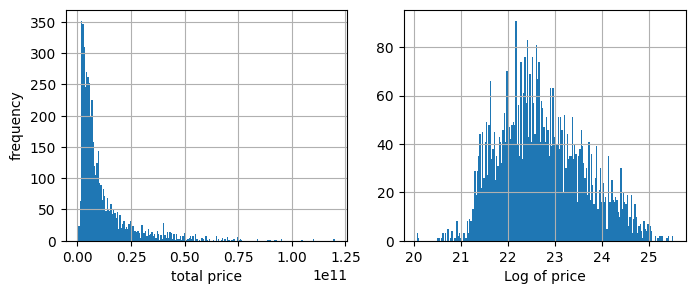

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)
cleaned_df["price"].hist(ax=axs[0], bins=200)
cleaned_df["price"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=200)
axs[0].set_xlabel("total price")
axs[1].set_xlabel("Log of price")
axs[0].set_ylabel("frequency")
plt.show()

#### meter

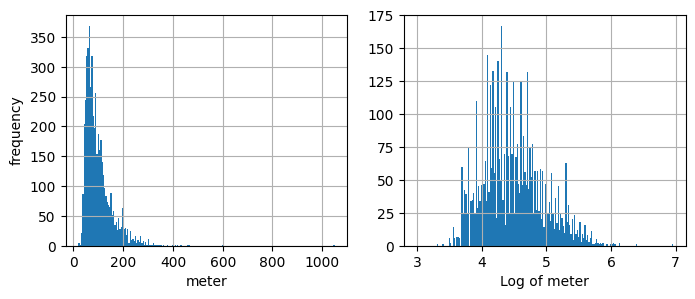

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)
cleaned_df["meter"].hist(ax=axs[0], bins=200)
cleaned_df["meter"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=200)
axs[0].set_xlabel("meter")
axs[1].set_xlabel("Log of meter")
axs[0].set_ylabel("frequency")
plt.show()

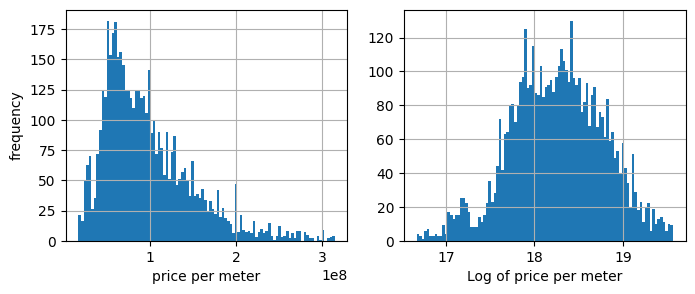

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=False)
cleaned_df["price_m2"].hist(ax=axs[0], bins=100)
cleaned_df["price_m2"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=100)
axs[0].set_xlabel("price per meter")
axs[1].set_xlabel("Log of price per meter")
axs[0].set_ylabel("frequency")
plt.show()

#### 

#### Age

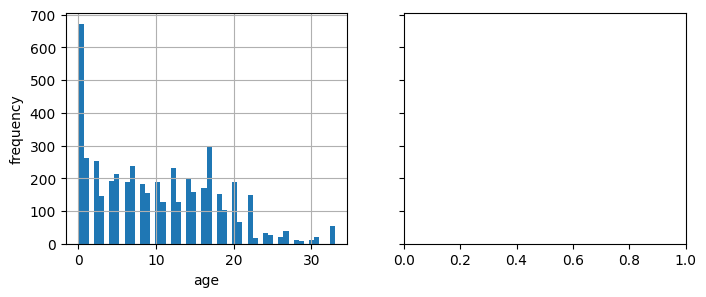

In [14]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
cleaned_df["age"].hist(ax=axs[0], bins=50)
# cleaned_df["age"].apply(lambda x: np.log(x)).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("age")
# axs[1].set_xlabel("Log of age")
axs[0].set_ylabel("frequency")
plt.show()

### preprocessing & pipelines

In [15]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer , make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

#### X, y selection

In [17]:
X = cleaned_df.drop(['price', 'price_m2'], axis=1)
y_price = cleaned_df['price']
y = cleaned_df['price_m2']

In [18]:
num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

In [19]:
cat_pipeline = make_pipeline(
      SimpleImputer(strategy="most_frequent"),
      OneHotEncoder(handle_unknown="ignore"))

In [20]:
log_pipeline = make_pipeline(
    SimpleImputer(strategy="median"),
    FunctionTransformer(np.log, feature_names_out="one-to-one"),
    StandardScaler())

In [21]:
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)

In [22]:
cat_attributes = ['business_type', 'district' , 'elevator', 'parking', 'depot', 'real_state_agent', 'if_near']
ordinal_attributes = ['floor_0', 'rooms']
num_attributes = ['age', 'meter']

preprocessing_1 = ColumnTransformer([
    ('cat', cat_pipeline, cat_attributes),
    ('num', num_pipeline, num_attributes),
    ('ord', num_pipeline, ordinal_attributes)],
     remainder='drop')

In [23]:
cat_attributes_2 = ['business_type', 'district' , 'elevator', 'parking', 'depot', 'real_state_agent','floor_0', 'rooms','if_near']
num_attributes_2= ['age', 'meter']

preprocessing_2 = ColumnTransformer([
    ('cat', cat_pipeline, cat_attributes_2),
    ('num', num_pipeline, num_attributes_2)],
     remainder='drop')

#### train test split

In [24]:
from sklearn.model_selection import train_test_split

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
XX_train, XX_test, yy_train, yy_test = train_test_split(X, y_price)

# Model Train and Prediction

#### linear_regression senario-1

In [27]:
from sklearn.linear_model import LinearRegression

In [28]:
lin_reg = make_pipeline(preprocessing_1, LinearRegression())
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'meter']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['floor_0', 'rooms'])])),
                ('linearregression', LinearRegression())])

#### evaluation - linear regression

In [29]:
y_predict_lr = lin_reg.predict(X_test)

print('r2 square : ', r2_score(y_test, y_predict_lr))
print('mean squared error : ', mean_squared_error(y_test, y_predict_lr, squared=False))
print('mean absolute error : ', mean_absolute_error(y_test, y_predict_lr))
print('mean absolute percentage error : ', mean_absolute_percentage_error(y_test, y_predict_lr))

r2 square :  0.8257820180786055
mean squared error :  22906018.852567106
mean absolute error :  15451846.084234508
mean absolute percentage error :  0.18038943771161262


In [30]:
lin_reg = make_pipeline(preprocessing_1, LinearRegression())
lin_reg.fit(XX_train, np.log(yy_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'meter']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['floor_0', 'rooms'])])),
                ('linearregression', LinearRegression())])

In [31]:
yy_predict_lr = np.exp(lin_reg.predict(XX_test))

print('r2 square : ', r2_score(yy_test, yy_predict_lr))
print('mean squared error : ', mean_squared_error(yy_test, yy_predict_lr, squared=False))
print('mean absolute error : ', mean_absolute_error(yy_test, yy_predict_lr))
print('mean absolute percentage error : ', mean_absolute_percentage_error(yy_test, yy_predict_lr))

r2 square :  -248.8322989126689
mean squared error :  196954907513.93536
mean absolute error :  7399004583.52738
mean absolute percentage error :  0.32728897864649686


#### senario - 2

In [32]:
lin_reg = make_pipeline(preprocessing_2, LinearRegression())
lin_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'floor_0', 'rooms',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'meter'])])),
                ('linearregression', LinearRegression())])

In [33]:
y_predict_lr = lin_reg.predict(X_test)

print('r2 square : ', r2_score(y_test, y_predict_lr))
print('mean squared error : ', mean_squared_error(y_test, y_predict_lr, squared=False))
print('mean absolute error : ', mean_absolute_error(y_test, y_predict_lr))
print('mean absolute percentage error : ', mean_absolute_percentage_error(y_test, y_predict_lr))

r2 square :  0.8244754821395215
mean squared error :  22991749.487415176
mean absolute error :  15528942.796683472
mean absolute percentage error :  0.18124598282963286


In [34]:
lin_reg = make_pipeline(preprocessing_2, LinearRegression())
lin_reg.fit(XX_train, np.log(yy_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'floor_0', 'rooms',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['age', 'meter'])])),
                ('linearregression', LinearRegression())])

In [35]:
yy_predict_lr = np.exp(lin_reg.predict(XX_test))

print('r2 square : ', r2_score(yy_test, yy_predict_lr))
print('mean squared error : ', mean_squared_error(yy_test, yy_predict_lr, squared=False))
print('mean absolute error : ', mean_absolute_error(yy_test, yy_predict_lr))
print('mean absolute percentage error : ', mean_absolute_percentage_error(yy_test, yy_predict_lr))

r2 square :  -3569.1810096196714
mean squared error :  744539309569.322
mean absolute error :  22952766180.959305
mean absolute percentage error :  0.710753020953765


#### xgboost  senario-1

In [36]:
import xgboost as xgb

In [37]:
xg_reg = make_pipeline(preprocessing_1, xgb.XGBRegressor(objective="reg:squarederror"))
xg_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

#### evaluatio xgboost senario -1

In [38]:
y_predict_xg = xg_reg.predict(X_test)

print('r2 square : ', r2_score(y_test, y_predict_xg))
print('mean squared error : ', mean_squared_error(y_test, y_predict_xg, squared=False))
print('mean absolute error : ', mean_absolute_error(y_test, y_predict_xg))
print('mean absolute percentage error : ', mean_absolute_percentage_error(y_test, y_predict_xg))

r2 square :  0.8028172861702348
mean squared error :  24368990.81292953
mean absolute error :  16820661.221155953
mean absolute percentage error :  0.19927912279001053


In [39]:
xg_reg = make_pipeline(preprocessing_1, xgb.XGBRegressor(objective="reg:squarederror"))
xg_reg.fit(XX_train, np.log(yy_train))

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [40]:
yy_predict_xg = np.exp(xg_reg.predict(XX_test))

print('r2 square : ', r2_score(yy_test, yy_predict_xg))
print('mean squared error : ', mean_squared_error(yy_test, yy_predict_xg, squared=False))
print('mean absolute error : ', mean_absolute_error(yy_test, yy_predict_xg))
print('mean absolute percentage error : ', mean_absolute_percentage_error(yy_test, yy_predict_xg))

r2 square :  0.918943153390795
mean squared error :  3547622221.1746297
mean absolute error :  1917386303.3730612
mean absolute percentage error :  0.19946898058272303


#### xgboost  senario-2

In [41]:
xg_reg = make_pipeline(preprocessing_2, xgb.XGBRegressor(objective="reg:squarederror"))
xg_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'floor_0', 'rooms',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimpu...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=None,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=None, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=None, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

#### evaluatio xgboost senario -2

In [42]:
y_predict_xg = xg_reg.predict(X_test)

print('r2 square : ', r2_score(y_test, y_predict_xg))
print('mean squared error : ', mean_squared_error(y_test, y_predict_xg, squared=False))
print('mean absolute error : ', mean_absolute_error(y_test, y_predict_xg))
print('mean absolute percentage error : ', mean_absolute_percentage_error(y_test, y_predict_xg))

r2 square :  0.8041854328071807
mean squared error :  24284301.880366776
mean absolute error :  16834261.104784023
mean absolute percentage error :  0.1998486012892433


# Ensamble 

In [148]:
from sklearn.ensemble import VotingRegressor

from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score,train_test_split
import xgboost as xgb

clf2 = RandomForestRegressor(n_estimators=50, random_state=1)
clf3 = xgb.XGBRegressor(objective="reg:squarederror")
clf4 = SVR()
clf5 = MLPRegressor()
clf6 = KNeighborsRegressor()

voting_reg = VotingRegressor(estimators=[
    ('rf', clf2),
    ('xgb', clf3),
    # ('svr', clf4),
    # ('mlp', clf5),
    ('knn',clf6)
],
n_jobs=-1) # weights=None, verbose=False
voting_reg

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(n_estimators=50,
                                                   random_state=1)),
                            ('xgb',
                             XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          im...
                                          interaction_constraints=None,
                                          learning_rate=None, max_bin=None,
                                          max_cat_threshold=None,
                                          max_cat_to_onehot=None,
                                          max_delta_step=None, max_depth=None,
                                          max_leaves=None,
                                          min_child_weight=None, missing=nan,
                                          monotone_constraints=None,
                                          multi_strategy=None,
                                          n_estimators=None, n_jobs=None,
                                          num_parallel_tree=None,
                                          random_state=None, ...)),
                            ('knn', KNeighborsRegressor())],
                n_jobs=-1)

In [149]:
pipline = make_pipeline(voting_reg)

In [150]:
vote_reg = make_pipeline(preprocessing_1, voting_reg)

In [151]:
vote_reg.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['business_type', 'district',
                                                   'elevator', 'parking',
                                                   'depot', 'real_state_agent',
                                                   'if_near']),
                                                 ('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer...
                                                           interaction_constraints=None,
                                                           learning_rate=None,
                                                           max_bin=None,
                                                           max_cat_threshold=None,
                                                           max_cat_to_onehot=None,
                                                           max_delta_step=None,
                                                           max_depth=None,
                                                           max_leaves=None,
                                                           min_child_weight=None,
                                                           missing=nan,
                                                           monotone_constraints=None,
                                                           multi_strategy=None,
                                                           n_estimators=None,
                                                           n_jobs=None,
                                                           num_parallel_tree=None,
                                                           random_state=None, ...)),
                                             ('knn', KNeighborsRegressor())],
                                 n_jobs=-1))])

In [152]:
y_predict = vote_reg.predict(X_test)

In [153]:
from sklearn import metrics

In [154]:
metrics.mean_absolute_error(y_test, y_predict)

16261691.186358538

In [155]:
metrics.r2_score(y_test, y_predict)

0.8038324048500698

In [156]:
estimator = ['rf', 'xgb' ,'svr','mlp', 'k']
for est in estimator:  # @ TODO
    pass
    # print( "estimator= ", est, 'Score= ', vote_reg[1].named_estimators_[est].score(X_test,y_test))

In [ ]:
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor

# bag_clf = BaggingRegressor(DecisionTreeRegressor(), n_estimators=10,max_samples=100,n_jobs=-1, random_state=0, oob_score=True ).fit(X_train,y_train)